As a scientist, watching the Brexit vote was a little bit painful. Though probably not for the reason you're thinking. No, it wasn't the politics that bothered me, but the method for making such an incredibly important decision. Let me explain...

Scientists are a bit obsessed with the concept of error. In the context of collecting data and anaylzing it, this takes the form of our "confidence" in the results. If all the data say the same thing, then we are usually pretty confident in the overall message. If the data is more complicated than this (and it always is), then we need to define *how confident* we are in our conclusions.

Which brings me to this gigantic nation-wide referendum vote. I couldn't help but notice that the cutoff for winning / losing the vote was set at 50%. To me, this sounds crazy. If I simply flipped a coin at 50% and tallied the results each time, I'd get some difference between # heads and # tails that would vary around 50%. In the context of voting, it means that a yes/no split that's really close to 50% might actually be too close to call.

In science, saying that a number is *different* from some other number requires that the difference falls outside of a certain region of uncertainty. It's a way of saying "yeah, I know that random fluctuations cause strange looking data sometimes, but my difference is *so far* from those fluctuations that I think there's something real going on."

But this is all a little abstract, so let's try it out on some voting data...

# Simulating a national referendum vote
For a referendum vote to go through, it seems reasonable to say "the people need to vote in numbers that are significantly different from random chance. To ask what "random chance" looks like, we can use computer simulations.

We'll take on the task of assessing what national votes might look like if they happened completely randomly. Then, we can compare the actual results to our simulation in order to decide if we've got a "real" result or not.

In [ ]:
# First, import a bunch of stuff that we'll use later
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [ ]:
# Initializing the simulation
# We'll simulate ten thousand votes.
# On each iteration, generate random votes and calculate the results 
n_votes = 10000

# This is the actual difference in percentage points that we had between the sides
actual_diff = 51.9 - 48.1

First, we'll create a completely random vote. Each person randomly chooses between the two options: *yes* and *no*. Then, we compare the difference in percentage points between the two.

In [ ]:
# Create 10,000 citizens and assign each a random vote
total_population = int(1e4)
diff = np.zeros(n_votes)
for ii in tqdm(range(n_votes)):
    votes = np.random.rand(total_population)
    yes = np.sum(votes < .5) / float(total_population)
    no = np.sum(votes > .5) / float(total_population)
    
    # This is the difference in percentage points
    diff[ii] = (yes - no) * 100

`diff` is a list of numbers representing the lead that "yes" has over "no".  Remember, we've randomly chosen these values, so they are the results you'd get if every single person in the country voted completely randomly.

How can we summarize the "limits of uncertainty" that `diff` defines? We can use percentiles to get an idea for the variability of this number. We'll take the 1st and the 99th percentile of our simulated differences as a proxy for the limits of what we'd expect if there were *no* true opinion in the population

In [ ]:
# Here we calculate 98% confidence interval on the difference
clo, chi = np.percentile(diff, [1, 99])

Now, we'll make a plot with 3 things:

1. The distribution of all our simulated differences
2. A vertical black line for each limit of the confidence interval.
3. A vertical red line representing the actual difference between yes/no that was reported

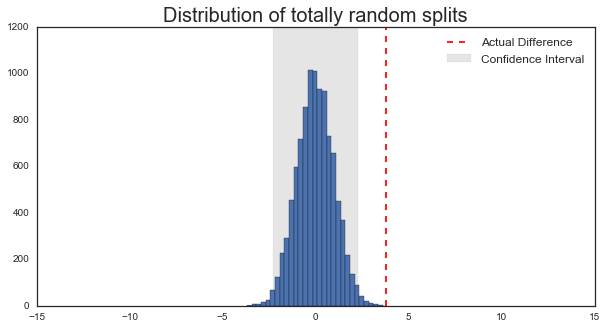

In [ ]:
# Let's look at the distribution of differences when voting is *totally* random
f, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(diff, bins=30)
_ = ax.axvline(actual_diff, color='r', ls='--')
axfill = ax.fill_between([clo, chi], *ax.get_ylim(), alpha=.1, color='k')
ax.set_title('Distribution of totally random splits', fontsize=20)
ax.legend([ax.lines[0], axfill], ['Actual Difference', 'Confidence Interval'], fontsize=12)
_ = plt.setp(ax, xlim=[-15, 15])

For a vote to be "different" than 50%, it'd need to be outside our margin of error described by the grey rectangle. In this case, it seems that a totally random vote yields about 2% points of spread around 0, and that the recorded vote difference (~4%) is outside of the margin of error for 50%. So maybe we can conclude that the Brexit vote was significantly different from a random 50/50 vote.

BUT - we also know that people don't vote completely randomly. They are influenced by external factors, they talk to one another, they tend to vote similarly to those around them. This is why everybody could predict which districts would vote "yes" and which would vote "no" well before the election.

So, let's build that in to our simulation...

# Simulating a not-completely-random population
So how exactly do we simulate the fact that people don't vote *totally* randomly? There are a lot of ways to do this, but I'll take the semi-arbitrary decision to say that we could expect the same pattern of voting to occur *within a district*. That is - we can simulate random *district* votes instead of random *individual* votes. Moreover, we'll then weight that district's percentage split by an amount proportional to that district's size. Intuitively it doesn't seem like this should make much difference in our simulation (we're still totally randomly choosing the yes/no split), but let's see what happens...

First, I grabbed a list of each UK voting district, along with its size...

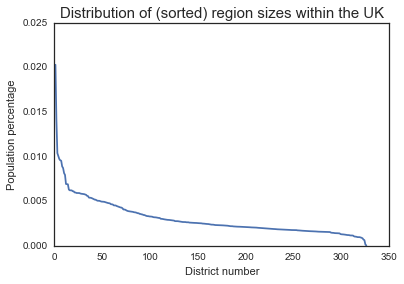

In [ ]:
# UK Population data pulled from
# https://en.wikipedia.org/wiki/List_of_English_districts_by_population
populations = pd.read_csv('../data/uk_population.csv', header=None, index_col=0)
header = ['District', 'Population', 'Type', 'Ceremonial_County', 'Historic_County', 'English_Region']
populations.columns = header

# Convert population to numbers
populations['Population'] = pd.to_numeric(populations['Population'].str.replace(',', ''))

# Now, turn these populations into percentages
n_areas = populations.shape[0]
total_population = populations['Population'].sum()
populations['percent'] = populations['Population'].astype(float) / total_population
plt.plot(populations['percent'])
plt.title('Distribution of (sorted) region sizes within the UK', fontsize=15)
plt.xlabel('District number')
plt.ylabel('Population percentage')

Now, we'll run the simulation. On each iteration, all the districts vote totally randomly. Then, the difference between "yes" and "no" is calculated for each. Finally, these differences are combined in a weighted average, where the weights are proportional to the district sizes. This means that bigger districts have a larger influence on the outcome, mimicking the way that the UK tallies votes.

In [ ]:
diff = np.zeros(n_votes)
for ii in tqdm(range(n_votes)):
    # Define a random split yes vs. no for each area
    area_splits = np.random.rand(n_areas)
    area_splits = np.vstack([area_splits, 1 - area_splits])
    yes, no = area_splits
    
    # Now, calculate the difference and average these together, weighted by the area size
    diffs = yes - no
    diffs = np.average(diffs, weights=populations['percent'])
    diff[ii] = diffs * 100

In [ ]:
# Here we calculate 99% confidence interval on the difference
clo, chi = np.percentile(diff, [.5, 99.5])

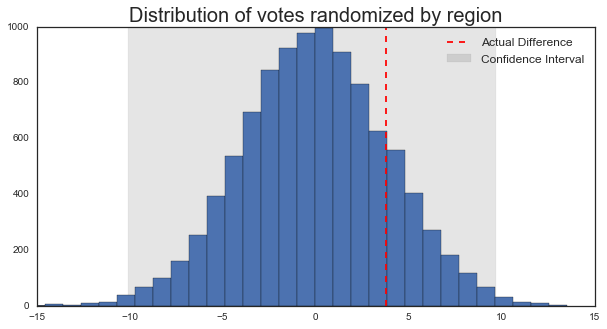

In [ ]:
# Let's look at the distribution of differences
# This time, voting is randomized for each region
f, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(diff, bins=30)
_ = ax.axvline(actual_diff, color='r', ls='--')
axfill = ax.fill_between([clo, chi], *ax.get_ylim(), alpha=.1, color='k')
ax.set_title('Distribution of votes randomized by region', fontsize=20)
ax.legend([ax.lines[0], axfill], ['Actual Difference', 'Confidence Interval'], fontsize=12)
_ = plt.setp(ax, xlim=[-15, 15])

Now we see a different sort of picture. Randomizing votes by district instead of by individual greatly increased the variability in the outcome. So much so that the "true" results from the Brexit now fall well within our confidence interval.

# Concluding thoughts?
So what can we conclude from something like this? The point of this article isn't to say that this particular simulation proves anything about the Brexit vote, but it does bring up an important point: we need to account for randomness whenever we aggregate data that we've collected.

When deciding whether to make a gigantic decision that will affect millions of people, we should be reasonably certain that the people's opinion is clear. Choosing a 50/50 split as a cutoff means that we could potentially make such a decision because of random chance. Doesn't sound like a great way to conduct national policy to me.

What could we do instead? There's the hard part. But the short answer is that we could include some idea of random variability in our voting rules. For example, we could require that this kind of "should we deviate from the norm" decision exceeds the results expected from a totally random vote. Settling on this uncertainty limit is not a simple task, but then again I wouldn't want to bet 2 trillion dollars worth of global economy on a coin flip.

# Extra: Adding a short term swing
As I mentioned above, deciding how to simulate the votes involves making assumptions about how things will go. I tried to keep the simulation as simple as possible in order to make a point, but you could include extra components as well.

For example, what if we chose a random subset of districts in the UK and swung their vote several percentage points in one random direction? This might happen if an eye-catching event caused sentiment to momentarily swing in one direction or another. In the long run each district's sentiment would probably ease back into it's "natural" split, but since votes happen on one day, these short-term factors can play an important role.

We can build this into our simulation...

In [ ]:
# Here we define a percentage of districts that undergo a sudden swing in voter opinion
perc_swing_amt = .1
perc_swing_districts = .2
n_perc_swing_districts = int(n_areas * perc_swing_districts)

In [ ]:
# Now, re-run the simulation including the random swing.
diff = np.zeros(n_votes)
for ii in tqdm(range(n_votes)):
    # Define a random split yes vs. no for each area
    area_splits = np.random.rand(n_areas)
    
    # Define a random swing across a subset of random districts
    swing = perc_swing_amt * np.random.choice([-1, 1])
    ixs_swing = np.random.choice(range(n_areas), n_perc_swing_districts, replace=False)
    area_splits[ixs_swing] = np.clip(swing + area_splits[ixs_swing], 0, 100)
    
    # Now calculate the opposing side amount and average
    area_splits = np.vstack([area_splits, 1 - area_splits])
    yes, no = area_splits
    
    # Now, calculate the difference and average these together, weighted by the area size
    diffs = yes - no
    diffs = np.average(diffs, weights=populations['percent'])
    diff[ii] = diffs * 100

In [ ]:
# Here we calculate 99% confidence interval on the difference
clo, chi = np.percentile(diff, [.5, 99.5])

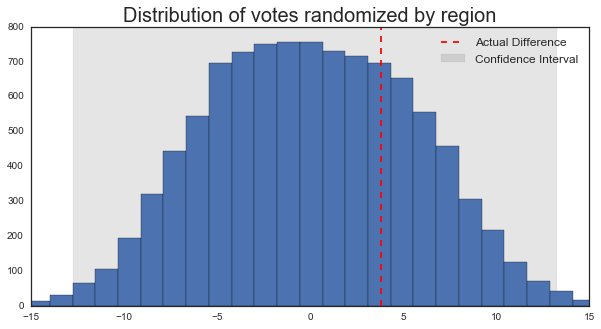

In [ ]:
# Let's look at the distribution of differences
f, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(diff, bins=30)
_ = ax.axvline(actual_diff, color='r', ls='--')
axfill = ax.fill_between([clo, chi], *ax.get_ylim(), alpha=.1, color='k')
ax.set_title('Distribution of votes randomized by region', fontsize=20)
ax.legend([ax.lines[0], axfill], ['Actual Difference', 'Confidence Interval'], fontsize=12)
_ = plt.setp(ax, xlim=[-15, 15])

It looks like now our confidence intervals are even wider than before. This is becase basically any change to our voting system that deviates away from a completely random 50/50 split will increase the variability in the outcome.